In [1]:
import logging
import math
import multiprocessing as mp
import numpy as np
import polars as pl
import psutil
import random
import time

from concurrent.futures import ProcessPoolExecutor, as_completed
from dataclasses import dataclass
from pathlib import Path
from scipy import stats
from shuffle_worker import process_batch_worker
from typing import List, Set, Dict, Tuple, Optional, NamedTuple


In [8]:

level = 2
cube_size = 2**level

image_source = '../pbgnn/data/shapenet_config_ortho_vis_1_128'

angle_id = 18


In [ ]:


pbrt_pixel_to_pos = np.load(f'{image_source}/pixel_to_pos_1_{angle_id}.npy')

intersect_mask = pbrt_pixel_to_pos[..., -1].astype(bool).flatten()
coords = pbrt_pixel_to_pos[..., 1:4].reshape(-1, 3)[intersect_mask]

9484 9484


In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
@dataclass
class UniformityTestResult:
    """Results from uniformity testing"""
    component_name: str
    chi2_statistic: float
    p_value: float
    degrees_of_freedom: int
    n_bins: int
    sample_size: int
    is_uniform: bool
    uniformity_score: float
    observed_frequencies: List[int]
    expected_frequencies: List[float]
    bin_edges: List[float]
    unique_values: Optional[List] = None  # For discrete components

@dataclass
class ChunkTestResult:
    """Results from testing a single chunk"""
    chunk_file: str
    chunk_index: int
    total_rows: int
    sample_size: int
    component_results: Dict[str, UniformityTestResult]
    overall_uniform: bool
    avg_uniformity_score: float
    failed_components: List[str]

class RayIDComponents(NamedTuple):
    """Decoded ray ID components"""
    face_index: int
    grid_index: int
    hemisphere_index: int

class RayIDUniformityTester:
    def __init__(self, 
                 n_faces: int = 6,
                 grid_resolution: int = 128,
                 hemisphere_divisions: int = 8,
                 rays_per_combination: int = 636,
                 alpha: float = 0.05
                 ):
        """
        Initialize ray ID uniformity tester
        
        Args:
            n_faces: Number of cube faces (usually 6)
            grid_resolution: Grid resolution per face (if None, auto-detect)
            hemisphere_divisions: Number of hemisphere divisions (if None, auto-detect)
            rays_per_combination: Rays per combination (if None, auto-detect)
            alpha: Significance level for hypothesis test
            auto_detect_params: Whether to auto-detect parameters from data
        """
        self.n_faces = n_faces
        self.grid_resolution = grid_resolution
        self.hemisphere_divisions = hemisphere_divisions
        self.rays_per_combination = rays_per_combination
        self.alpha = alpha
                
        logger.info(f"Initialized Ray ID uniformity tester")
        logger.info(f"Faces: {n_faces}, Alpha: {alpha}")
        
    def _test_discrete_uniformity(self, values: np.ndarray, component_name: str, 
                                expected_range: Tuple[int, int]) -> UniformityTestResult:
        """
        Test uniformity for discrete components (like face_id, grid positions)
        
        Args:
            values: Array of discrete values
            component_name: Name of the component
            expected_range: (min_value, max_value) expected
            
        Returns:
            UniformityTestResult
        """
        min_val, max_val = expected_range
        n_categories = max_val - min_val + 1
        
        # Count occurrences of each value
        unique_vals, counts = np.unique(values, return_counts=True)
        
        # Create full frequency array (including zero counts)
        observed_freq = np.zeros(n_categories, dtype=int)
        for val, count in zip(unique_vals, counts):
            if min_val <= val <= max_val:
                observed_freq[val - min_val] = count
        
        # Expected frequencies (uniform distribution)
        total_samples = len(values)
        expected_freq = np.full(n_categories, total_samples / n_categories)
        
        # Chi-squared test
        chi2_stat, p_value = stats.chisquare(observed_freq, expected_freq)
        
        # Results
        is_uniform = p_value > self.alpha
        
        # Uniformity score
        max_possible_chi2 = total_samples * (n_categories - 1)
        uniformity_score = max(0.0, 1.0 - (chi2_stat / max_possible_chi2))
        
        # Create bin edges for discrete values
        bin_edges = list(range(min_val, max_val + 2))  # +2 for proper binning
        
        logger.debug(f"Component {component_name}: χ²={chi2_stat:.4f}, p={p_value:.6f}, "
                    f"uniform={is_uniform}, score={uniformity_score:.4f}")
        
        return UniformityTestResult(
            component_name=component_name,
            chi2_statistic=chi2_stat,
            p_value=p_value,
            degrees_of_freedom=n_categories - 1,
            n_bins=n_categories,
            sample_size=total_samples,
            is_uniform=is_uniform,
            uniformity_score=uniformity_score,
            observed_frequencies=observed_freq.tolist(),
            expected_frequencies=expected_freq.tolist(),
            bin_edges=bin_edges,
            unique_values=unique_vals.tolist()
        )
    
    def _load_and_sample_single_chunk(self, chunk_file: str, 
                                    sample_size: Optional[int] = None, 
                                    seed: int = 42) -> pl.DataFrame:
        """Load a single chunk file and optionally sample from it"""
        chunk_path = Path(chunk_file)
        if not chunk_path.exists():
            raise FileNotFoundError(f"Chunk file does not exist: {chunk_file}")
        
        # Load the chunk
        chunk_df = pl.read_parquet(chunk_path)
        
        # Validate that ray_id column exists
        if 'ray_id' not in chunk_df.columns:
            raise ValueError(f"Missing ray_id column in {chunk_file}")
        
        total_rows = len(chunk_df)
        
        # Sample if requested and if chunk is larger than sample size
        if sample_size is not None and total_rows > sample_size:
            logger.debug(f"Sampling {sample_size:,} rows from {total_rows:,} total rows in {chunk_path.name}")
            try:
                sampled_df = chunk_df.sample(n=sample_size, seed=seed)
            except:
                # Fallback: manual sampling with indices
                np.random.seed(seed)
                indices = np.random.choice(total_rows, size=sample_size, replace=False)
                sampled_df = chunk_df[sorted(indices)]
        else:
            logger.debug(f"Using all {total_rows:,} rows from {chunk_path.name}")
            sampled_df = chunk_df
        
        return sampled_df
    
    def _test_single_chunk(self, chunk_file: str, chunk_index: int, 
                          sample_size: Optional[int] = None, seed: int = 42) -> ChunkTestResult:
        """Test uniformity for ray ID components in a single chunk"""
        chunk_path = Path(chunk_file)
        logger.info(f"Testing chunk {chunk_index + 1}: {chunk_path.name}")
        
        try:
            # Load chunk data
            chunk_df = self._load_and_sample_single_chunk(chunk_file, sample_size, seed + chunk_index)
            total_rows = len(chunk_df)
            actual_sample_size = len(chunk_df)
                                    
            components = {
               'face_index': chunk_df.select('face_id').to_numpy().astype(int),
               'grid_index': chunk_df.select('grid_id').to_numpy().astype(int),
               'hemisphere_index': chunk_df.select('hemisphere_id').to_numpy().astype(int),
            }
            
            # Test each component for uniformity
            component_results = {}
            failed_components = []
            
            # Test face indices (0 to n_faces-1)
            face_result = self._test_discrete_uniformity(
                components['face_index'], 'face_index', (0, self.n_faces - 1))
            component_results['face_index'] = face_result
            if not face_result.is_uniform:
                failed_components.append('face_index')
            
            # Test grid indices (0 to grid_resolution²-1)
            grid_max = self.grid_resolution * self.grid_resolution - 1
            grid_result = self._test_discrete_uniformity(
                components['grid_index'], 'grid_index', (0, grid_max))
            component_results['grid_index'] = grid_result
            if not grid_result.is_uniform:
                failed_components.append('grid_index')
            
            # Test hemisphere indices (0 to hemisphere_divisions-1)
            hemisphere_max = self.hemisphere_divisions - 1
            hemisphere_result = self._test_discrete_uniformity(
                components['hemisphere_index'], 'hemisphere_index', (0, hemisphere_max))
            component_results['hemisphere_index'] = hemisphere_result
            if not hemisphere_result.is_uniform:
                failed_components.append('hemisphere_index')
            
            # Calculate overall statistics
            avg_uniformity_score = np.mean([r.uniformity_score for r in component_results.values()])
            overall_uniform = len(failed_components) == 0
            
            logger.info(f"  Chunk {chunk_index + 1} results: {len(component_results)} components tested, "
                       f"uniform={overall_uniform}, avg_score={avg_uniformity_score:.4f}")
            
            return ChunkTestResult(
                chunk_file=str(chunk_path),
                chunk_index=chunk_index,
                total_rows=total_rows,
                sample_size=actual_sample_size,
                component_results=component_results,
                overall_uniform=overall_uniform,
                avg_uniformity_score=avg_uniformity_score,
                failed_components=failed_components
            )
            
        except Exception as e:
            logger.error(f"Failed to test chunk {chunk_index + 1} ({chunk_path.name}): {e}")
            return ChunkTestResult(
                chunk_file=str(chunk_path),
                chunk_index=chunk_index,
                total_rows=0,
                sample_size=0,
                component_results={},
                overall_uniform=False,
                avg_uniformity_score=0.0,
                failed_components=['all']
            )
    
    def test_chunks_uniformity(self, chunk_files: List[str], sample_size_per_chunk: Optional[int] = None, 
                             seed: int = 42) -> List[ChunkTestResult]:
        """Test uniformity of ray ID components for each chunk"""
        logger.info(f"\n{'='*80}")
        logger.info(f"RAY ID COMPONENT UNIFORMITY TESTING")
        logger.info(f"{'='*80}")
        logger.info(f"Testing {len(chunk_files)} chunks")
        if sample_size_per_chunk:
            logger.info(f"Sampling {sample_size_per_chunk:,} rows per chunk")
        else:
            logger.info(f"Using all rows in each chunk")
        
        results = []
        
        for chunk_index, chunk_file in enumerate(chunk_files):
            chunk_result = self._test_single_chunk(
                chunk_file, chunk_index, sample_size_per_chunk, seed)
            results.append(chunk_result)
        
        return results
    
    def print_detailed_report(self, results: List[ChunkTestResult]):
        """Print detailed report of ray ID component uniformity tests"""
        
        print(f"\n{'='*100}")
        print(f"RAY ID COMPONENT UNIFORMITY TEST REPORT")
        print(f"{'='*100}")
        
        if not results:
            print("No results to display!")
            return
                
        # Overall statistics
        total_chunks = len(results)
        successful_chunks = len([r for r in results if r.component_results])
        uniform_chunks = len([r for r in results if r.overall_uniform])
        
        print(f"\nOverall Statistics:")
        print(f"  Total chunks: {total_chunks}")
        print(f"  Successfully tested: {successful_chunks}/{total_chunks} ({successful_chunks/total_chunks*100:.1f}%)")
        print(f"  Fully uniform chunks: {uniform_chunks}/{successful_chunks} ({uniform_chunks/successful_chunks*100:.1f}%)")
        
        # Component-wise summary
        component_names = ['face_index', 'grid_index', 'hemisphere_index']
        
        print(f"\nComponent-wise Summary:")
        print(f"{'Component':<18} {'Chunks Tested':<13} {'Uniform Chunks':<14} {'Uniform %':<10} {'Avg Score':<10}")
        print(f"{'-'*75}")
        
        for component in component_names:
            component_data = []
            for result in results:
                if component in result.component_results:
                    component_data.append(result.component_results[component])
            
            if component_data:
                tested_count = len(component_data)
                uniform_count = len([r for r in component_data if r.is_uniform])
                uniform_pct = uniform_count / tested_count * 100
                avg_score = np.mean([r.uniformity_score for r in component_data])
                
                print(f"{component:<18} {tested_count:<13} {uniform_count:<14} {uniform_pct:<10.1f}% {avg_score:<10.4f}")
            else:
                print(f"{component:<18} {'0':<13} {'0':<14} {'0.0%':<10} {'0.0000':<10}")
        
        # Per-chunk summary (first 20 chunks)
        print(f"\nPer-Chunk Summary (first 20 chunks):")
        print(f"{'Chunk':<8} {'File':<25} {'Uniform':<8} {'Score':<8} {'Failed Components':<20}")
        print(f"{'-'*70}")
        
        for result in results[:20]:
            chunk_name = Path(result.chunk_file).name[:22] + "..." if len(Path(result.chunk_file).name) > 25 else Path(result.chunk_file).name
            uniform_str = "✓" if result.overall_uniform else "✗"
            failed_str = ",".join(result.failed_components[:3]) + ("..." if len(result.failed_components) > 3 else "")
            
            print(f"{result.chunk_index+1:<8} {chunk_name:<25} {uniform_str:<8} "
                  f"{result.avg_uniformity_score:<8.4f} {failed_str:<20}")
        
        if len(results) > 20:
            print(f"... and {len(results) - 20} more chunks")


In [4]:
@dataclass
class ShuffleConfig:
    """Configuration for shuffle operations"""
    max_memory_usage_ratio: float = 0.7  # Use 70% of available memory
    safety_margin: float = 0.9  # 90% of calculated max chunks
    min_chunks_per_batch: int = 2
    max_chunks_per_batch: int = 1000
    chunk_size_variation: Tuple[float, float] = (0.8, 1.2)  # Min, max variation
    max_workers: int = 1

In [ ]:
class MemoryAwareChunkShuffler:
    def __init__(self, input_dir: str, output_dir: str, temp_dir: str = "shuffle_temp", 
                 config = None):
        self.input_dir = Path(input_dir)
        self.output_dir = Path(output_dir)
        self.temp_dir = Path(temp_dir)
        self.config = config or ShuffleConfig()
        
        # Create directories
        self.output_dir.mkdir(exist_ok=True, parents=True)
        self.temp_dir.mkdir(exist_ok=True, parents=True)
        
        # Get all input chunk files
        self.input_chunks = list(self.input_dir.glob("*.parquet"))
        if not self.input_chunks:
            raise ValueError(f"No parquet files found in {input_dir}")
        
        logger.info(f"Found {len(self.input_chunks)} input chunks")
        
        # Initialize tracking
        self.processed_chunks = set()
        self.memory_stats = self._get_memory_info()
        self.chunk_memory_usage = self._estimate_chunk_memory()
        self.optimal_batch_size = self._calculate_optimal_batch_size()
        self.required_passes = self._calculate_required_passes()
        
        logger.info(f"Memory available: {self.memory_stats['available_gb']:.1f} GB")
        logger.info(f"Estimated chunk memory: {self.chunk_memory_usage / 1024**2:.1f} MB")
        logger.info(f"Optimal batch size: {self.optimal_batch_size} chunks")
        logger.info(f"Required passes: {self.required_passes}")
    
    def _get_memory_info(self) -> Dict[str, float]:
        """Get current memory information"""
        memory = psutil.virtual_memory()
        return {
            'total_gb': memory.total / 1024**3,
            'available_gb': memory.available / 1024**3,
            'used_gb': memory.used / 1024**3,
            'percent_used': memory.percent
        }
    
    def _estimate_chunk_memory(self, sample_size: int = 3) -> float:
        """Estimate memory usage per chunk by sampling"""
        sample_files = random.sample(self.input_chunks, min(sample_size, len(self.input_chunks)))
        memory_usages = []
        
        for file_path in sample_files:
            try:
                # Load chunk and measure memory
                chunk = pl.read_parquet(file_path)
                memory_usage = chunk.estimated_size()
                memory_usages.append(memory_usage)
                logger.debug(f"Chunk {file_path.name}: {memory_usage / 1024**2:.1f} MB")
            except Exception as e:
                logger.warning(f"Could not estimate memory for {file_path}: {e}")
        
        if not memory_usages:
            # Fallback estimate
            return 100 * 1024**2  # 100MB default
        
        avg_memory = sum(memory_usages) / len(memory_usages)
        # Add buffer for processing overhead
        return avg_memory * 1.5
    
    def _calculate_optimal_batch_size(self) -> int:
        """Calculate optimal number of chunks to process in one batch"""
        available_memory = self.memory_stats['available_gb'] * 1024**3 / self.config.max_workers
        usable_memory = available_memory * self.config.max_memory_usage_ratio
        
        # Calculate theoretical max chunks
        theoretical_max = int(usable_memory / self.chunk_memory_usage)
        
        # Apply safety margin and constraints
        safe_max = int(theoretical_max * self.config.safety_margin)
        optimal_size = max(
            self.config.min_chunks_per_batch,
            min(safe_max, self.config.max_chunks_per_batch)
        )
        
        logger.debug(f"Theoretical max chunks: {theoretical_max}")
        logger.debug(f"Safe max chunks: {safe_max}")
        
        return optimal_size
    
    def _calculate_required_passes(self) -> int:
        """Calculate number of shuffle passes needed for uniform distribution"""
        n_chunks = len(self.input_chunks)
        k_batch_size = self.optimal_batch_size
        
        if k_batch_size >= n_chunks:
            # Can process all chunks at once
            return 1
        
        # Theoretical passes based on k-way merging
        theoretical_passes = math.ceil(math.log(n_chunks) / math.log(k_batch_size))
        
        # Additional mixing passes for uniformity
        mixing_passes = max(1, math.ceil(math.log2(n_chunks) * 0.3))
        
        total_passes = theoretical_passes + mixing_passes
        
        logger.debug(f"Theoretical passes: {theoretical_passes}")
        logger.debug(f"Mixing passes: {mixing_passes}")
        
        return min(total_passes, 10)  # Cap at 10 passes
    
    def _select_random_chunks_for_batch(self, available_chunks: List[Path], 
                                      batch_size: int) -> List[Path]:
        """Select random chunks for processing, avoiding already processed ones"""
        # Filter out already processed chunks
        unprocessed_chunks = [chunk for chunk in available_chunks 
                            if chunk not in self.processed_chunks]
        
        if not unprocessed_chunks:
            # Reset for new pass
            self.processed_chunks.clear()
            unprocessed_chunks = available_chunks.copy()
            logger.info("Reset processed chunks tracker for new pass")
        
        # Select random batch
        batch_size = min(batch_size, len(unprocessed_chunks))
        selected_chunks = random.sample(unprocessed_chunks, batch_size)
        
        # Mark as processed
        self.processed_chunks.update(selected_chunks)
        
        return selected_chunks
        
    def _cleanup_files(self, files: List[Path]):
        """Clean up temporary files"""
        for file_path in files:
            try:
                if file_path.exists():
                    file_path.unlink()
                    logger.debug(f"Deleted {file_path.name}")
            except Exception as e:
                logger.warning(f"Could not delete {file_path}: {e}")
    
    def _perform_shuffle_pass_parallel(self, input_chunks: List[Path], pass_number: int, 
                                      seed: int, max_workers: int = None) -> List[Path]:
        """Perform one complete shuffle pass with parallel batch processing"""
        logger.info(f"\n{'='*50}")
        logger.info(f"SHUFFLE PASS {pass_number} (PARALLEL)")
        logger.info(f"{'='*50}")
        
        # Reset processed tracker for this pass
        self.processed_chunks.clear()
        
        # Estimate target chunk size for output
        total_input_chunks = len(input_chunks)
        
        # Sample a chunk to estimate average rows per chunk
        if input_chunks:
            sample_chunk = pl.read_parquet(input_chunks[0])
            avg_rows_per_chunk = len(sample_chunk)
        else:
            avg_rows_per_chunk = 10000
        
        # Prepare all batches upfront
        batches = []
        chunk_offset = 0
        batch_number = 0
        
        remaining_chunks = input_chunks.copy()
        random.shuffle(remaining_chunks)  # Randomize order
        
        while remaining_chunks:
            batch_number += 1
            batch_size = min(self.optimal_batch_size, len(remaining_chunks))
            batch_chunks = remaining_chunks[:batch_size]
            remaining_chunks = remaining_chunks[batch_size:]
            
            # Estimate output chunks for this batch
            estimated_rows = avg_rows_per_chunk * len(batch_chunks)
            estimated_output_chunks = math.ceil(estimated_rows / avg_rows_per_chunk)
            
            batches.append({
                'chunks': batch_chunks,
                'batch_number': batch_number,
                'chunk_offset': chunk_offset
            })
            
            # Reserve space for output chunks from this batch
            chunk_offset += estimated_output_chunks * 2  # 2x buffer for variation
        
        logger.info(f"Prepared {len(batches)} batches for parallel processing")
        
        # Process batches in parallel
        all_output_chunks = []
        
        if max_workers is None:
            max_workers = min(len(batches), self.config.max_workers if hasattr(self.config, 'max_workers') else 4)
        
        with ProcessPoolExecutor(max_workers=max_workers, mp_context=mp.get_context('spawn')) as executor:
            # Submit all batch jobs
            future_to_batch = {}
            for batch_info in batches:
                future = executor.submit(
                    process_batch_worker,
                    batch_info['chunks'],
                    pass_number,
                    batch_info['batch_number'],
                    seed + batch_info['batch_number'],
                    avg_rows_per_chunk,
                    batch_info['chunk_offset'],
                    self.temp_dir,
                    self.config.chunk_size_variation
                )
                future_to_batch[future] = batch_info['batch_number']
            
            # Collect results as they complete
            for future in as_completed(future_to_batch):
                batch_num = future_to_batch[future]
                try:
                    output_files, num_chunks, status = future.result()
                    logger.info(status)
                    all_output_chunks.extend(output_files)
                except Exception as e:
                    logger.error(f"Batch {batch_num} failed with exception: {e}")
        
        # Clean up input chunks if they're temporary
        if pass_number > 1:
            self._cleanup_files(input_chunks)
        
        logger.info(f"Pass {pass_number} complete: {len(all_output_chunks)} total chunks created")
        return all_output_chunks
    
    def shuffle_dataset(self, seed: int = 42, use_parallel: bool = True, 
                       max_workers: int = None) -> List[Path]:
        """
        Perform complete multi-pass shuffle of the dataset.
        
        Args:
            seed: Random seed for reproducibility
            use_parallel: Whether to use parallel processing
            max_workers: Maximum number of parallel workers (None = auto)
        """
        logger.info(f"\n{'='*60}")
        logger.info(f"STARTING MULTI-PASS SHUFFLE {'(PARALLEL)' if use_parallel else ''}")
        logger.info(f"{'='*60}")
        logger.info(f"Input chunks: {len(self.input_chunks)}")
        logger.info(f"Required passes: {self.required_passes}")
        logger.info(f"Batch size: {self.optimal_batch_size}")
        if use_parallel:
            logger.info(f"Max workers: {max_workers or 'auto'}")
        
        current_chunks = self.input_chunks.copy()
        
        # Perform multiple shuffle passes
        for pass_num in range(1, self.required_passes + 1):
            import time
            start_time = time.time()
            
            if use_parallel:
                current_chunks = self._perform_shuffle_pass_parallel(
                    current_chunks, pass_num, seed * pass_num, max_workers)
            else:
                # Fallback to sequential processing (your original method)
                current_chunks = self._perform_shuffle_pass(
                    current_chunks, pass_num, seed * pass_num)
            
            pass_time = time.time() - start_time
            logger.info(f"Pass {pass_num} completed in {pass_time:.1f} seconds")
            
            # Update memory stats
            self.memory_stats = self._get_memory_info()
            logger.info(f"Memory usage: {self.memory_stats['percent_used']:.1f}%")

            tester = RayIDUniformityTester(
                grid_resolution=128,
                hemisphere_divisions=8,
                rays_per_combination=636,
                alpha=0.05,
            )
            results = tester.test_chunks_uniformity(current_chunks, 10000, 42)
            tester.print_detailed_report(results)
        
        # Move final chunks to output directory
        final_chunks = []
        for i, chunk_file in enumerate(current_chunks):
            final_path = self.output_dir / f"chunk_{i:04d}.parquet"
            try:
                chunk_file.rename(final_path)
                final_chunks.append(final_path)
            except Exception as e:
                logger.error(f"Failed to move {chunk_file} to {final_path}: {e}")

        tester = RayIDUniformityTester(
            grid_resolution=128,
            hemisphere_divisions=8,
            rays_per_combination=636,
            alpha=0.05,
        )
        results = tester.test_chunks_uniformity(final_chunks, 10000, 42)
        tester.print_detailed_report(results)
        
        # Clean up temp directory
        try:
            for temp_file in self.temp_dir.glob("*.parquet"):
                temp_file.unlink()
        except Exception as e:
            logger.warning(f"Error cleaning temp directory: {e}")
        
        logger.info(f"\n{'='*60}")
        logger.info(f"SHUFFLE COMPLETE!")
        logger.info(f"{'='*60}")
        logger.info(f"Final output: {len(final_chunks)} chunks in {self.output_dir}")
        
        return final_chunks

In [6]:
# Configure shuffle parameters
config = ShuffleConfig(
    max_memory_usage_ratio=0.4,  # Use 80% of available memory
    safety_margin=0.9,           # 90% safety margin
    min_chunks_per_batch=2,
    max_chunks_per_batch=100,
    max_workers=4
)

In [7]:
data_dir = Path('./data/nrt-mesh-intersection-dataset')
if not data_dir.exists():
    data_dir = Path('output') / 'ray_data'

input_data_dir = data_dir / 'results'
output_data_dir = data_dir / 'shuffled'

In [8]:
for joined_path in input_data_dir.glob('*'):
    # Create shuffler
    shuffler = MemoryAwareChunkShuffler(
        input_dir=joined_path,
        output_dir=output_data_dir / joined_path.name, 
        temp_dir="shuffle_temp",
        config=config
    )
    
    # Perform shuffle
    final_chunks = shuffler.shuffle_dataset(seed=42)        

    print(f"{joined_path.name} Shuffle complete! Created {len(final_chunks)} shuffled chunks.")

2025-10-05 23:10:50,296 - INFO - Found 51 input chunks


AttributeError: 'MemoryAwareChunkShuffler' object has no attribute 'max_workers'

In [31]:
import plotly.graph_objects as go

def decode_ray_ids(ray_ids: np.ndarray, params: Dict) -> Dict[str, np.ndarray]:
        """
        Decode multiple ray IDs efficiently using the user's decoding logic
        
        Args:
            ray_ids: Array of ray IDs
            params: Parameters from structure analysis
            
        Returns:
            Dictionary with component arrays
        """
        grid_resolution = params['grid_resolution']
        hemisphere_divisions = params['hemisphere_divisions']
        rays_per_combination = params['rays_per_combination']
        
        # User's decoding logic
        rays_per_face = grid_resolution * grid_resolution * hemisphere_divisions * rays_per_combination
        
        face_indices = ray_ids // rays_per_face
        remainder_after_face = ray_ids % rays_per_face
        
        rays_per_grid = hemisphere_divisions * rays_per_combination
        grid_indices = remainder_after_face // rays_per_grid
        remainder_after_grid = remainder_after_face % rays_per_grid
        
        hemisphere_indices = remainder_after_grid // rays_per_combination
        
        return {
            'face_index': face_indices,
            'grid_index': grid_indices,
            'hemisphere_index': hemisphere_indices
        }

df = pl.read_parquet('data/nrt-mesh-intersection-dataset/shuffled/Bistro_Research_Exterior_paris_building_05_47__5251/shuffled_chunk_0000.parquet')
face_indices, grid_indices, hemisphere_indices = decode_ray_ids(df['ray_id'], {
    'grid_resolution': 128,
    'hemisphere_divisions': 8,
    'rays_per_combination': 636
}).values()
sample_df = df.sample(n=100000)

In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Distribution 1', 'Distribution 2', 'Distribution 3')
)

# Add histograms to each subplot
fig.add_trace(
    go.Histogram(x=face_indices, name='Data 1', marker_color='blue'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=grid_indices, name='Data 2', marker_color='red'),
    row=1, col=2
)

fig.add_trace(
    go.Histogram(x=hemisphere_indices, name='Data 3', marker_color='green'),
    row=1, col=3
)

fig.show()

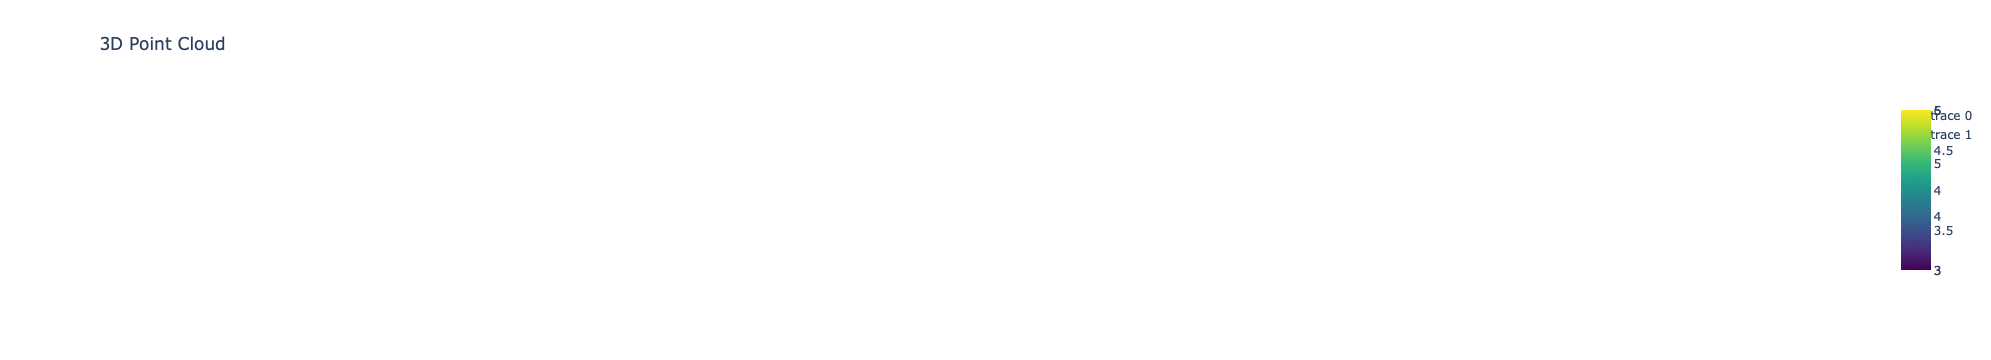

In [ ]:
positions = np.stack((sample_df['origin_x'], sample_df['origin_y'], sample_df['origin_z']), axis=-1)
directions = np.stack((np.arctan2(sample_df['direction_y'], sample_df['direction_x']), np.arccos(sample_df['direction_z'])), axis=-1)

is_visible = sample_df['hit'].to_numpy().astype(bool)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=positions[:, 0][is_visible],
    y=positions[:, 1][is_visible],
    z=positions[:, 2][is_visible],
    mode='markers',
    marker=dict(
        size=2,
        colorscale='Viridis',
        showscale=True
    )),
    go.Scatter3d(
    x=positions[:, 0][~is_visible],
    y=positions[:, 1][~is_visible],
    z=positions[:, 2][~is_visible],
    mode='markers',
    marker=dict(
        size=2,
        colorscale='Viridis',
        showscale=True
    )),
])

# Update layout
fig.update_layout(
    title='3D Point Cloud',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

fig.show()